In [1]:
import numpy as np
import pandas as pd
import time
import math
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import requests
from bs4 import BeautifulSoup
import itertools
from IPython.display import Markdown, display
from z3 import *
from functools import reduce

In [8]:

url='https://www.janestreet.com/puzzles/travel-agent-index/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
y =[text for text in soup.body.stripped_strings]
#display([(i,j) for i,j in enumerate(y)])
display(Markdown("### "+y[7]+"\n\n"+str("\n".join(y[8:9]))))

### Travel Agent

February 2016 : Puzzle

<img src="https://www.janestreet.com/puzzles/wp-content/uploads/2016/02/feb16_puzzle.png" width="350" >

In [9]:
fixed = [[1, 5, 4, 4, 6, 1, 1, 4, 1, 3, 7, 5],
         [3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
         [4, 0, 6, 4, 1, 8, 1, 4, 2, 1, 0, 3],
         [7, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 2],
         [1, 0, 1, 0, 6, 1, 6, 2, 0, 2, 0, 1],
         [8, 0, 4, 0, 1, 0, 0, 8, 0, 3, 0, 5],
         [4, 0, 2, 0, 5, 0, 0, 3, 0, 5, 0, 2],
         [8, 0, 5, 0, 1, 1, 2, 3, 0, 4, 0, 6],
         [6, 0, 1, 0, 0, 0, 0, 0, 0, 3, 0, 6],
         [3, 0, 6, 3, 6, 5, 4, 3, 4, 5, 0, 1],
         [6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
         [2, 1, 6, 6, 4, 5, 2, 1, 1, 1, 7, 1]]

example= [[3, 4, 1, 7, 5],
          [1, 2, 4, 3, 5],
          [2, 4, 3, 6, 2],
          [9, 5, 7, 2, 3],
          [5, 8, 3, 4, 1]]

path1= [0,5,10,11,12,7,8,9,14,19,24]
path =[0,1,13,14,26,25,37,49,61,73,85,97,109,108,120,121,122,123,124,125,126,127,128,116,104,92,80,68,56,55,43,42,41,53,65,
       77,78,90,102,101,100,99,87,75,63,62,50,51,52,40,39,27,15,16,17,18,19,20,32,33,21,9,10,22,34,46,45,57,58,70,82,94,106,
       118,130,142,143]+[143]*(143-77+1)
               
                  
def grid_print(grid,orig_grid,path):
    n = len(grid)/2.5
    fig,ax = plt.subplots(1,1,figsize=(n,n))    
    text = np.array(grid).astype('int').astype('str')
    text[text=="0"] == ""              
    ax =sns.heatmap(orig_grid,annot=text,cbar=False,cmap=ListedColormap(["w","r","yellow","green","orange","c","m","brown","grey","hotpink"],N=np.max(grid)),fmt="",
                    linewidths=2,linecolor="k",annot_kws={"size":12,"color":"k"},alpha=.2,vmin=0)
    ax.tick_params(left=False, bottom=False,labelleft=False, labelright=True)
    xpoints = [i //len(grid)+0.5 for i in path]
    ypoints = [i % len(grid)+0.5 for i in path]
    plt.plot(xpoints,ypoints,"r")
    plt.axis("off")
    plt.tight_layout()
    plt.show()   
                  
                  
#grid_print(fixed,fixed,path)   
#grid_print(example,example,path1)   

In [37]:
def solve_grid(grid):
    start = time.time()
    n =  len(grid)
    
    # set up Path,Matrix
    P = [Int("P_%s" % (i+1)) for i in range(n**2)]
    M = [Int("M_%s" % (i+1)) for i in range(n**2)]
    
    # Set up Dice Faces (Up Down Left Right Front Back)
    U = [Int("U_%s" % (i+1)) for i in range(n**2)]
    D = [Int("D_%s" % (i+1)) for i in range(n**2)]
    L = [Int("L_%s" % (i+1)) for i in range(n**2)]
    R = [Int("R_%s" % (i+1)) for i in range(n**2)]
    F = [Int("F_%s" % (i+1)) for i in range(n**2)]
    B = [Int("B_%s" % (i+1)) for i in range(n**2)]
    
    # set up the solver
    s = Optimize()
    
    s.maximize(Product([If(P[x]==y,M[y],1) for x in range(n**2) for y in range(n**2)]))
    
    # start and end cells
    s += P[0] == 0
    s += P[-1] == n**2-1
    
    # set up the matrix
    s += [And(m > 0, m <= int(np.max(grid))) for m in M]
    s += [M[i+j*n] == grid[i][j] for i in range(n) for j in range(n) if grid[i][j] !=0]
    
    # limit the dice and move values
    s += [And(p >= 0, p % n < n, p / n < n) for p in P] # division == integer division
    
    # no revisiting old cells
    s += [Or(P[j]!= P[i], P[j] == n**2-1) for i in range(n**2) for j in range(n**2) if i != j]
    s += [Implies(P[i-1]==n**2-1,P[i]==n**2-1) for i in range(1,n**2)]

    #can only move to neighbours
    moves = [(-1,0),(0,-1),(0,0),(1,0),(0,1)]
    s += [Or([And(P[i] % n - P[i-1] % n == x,P[i] / n - P[i-1] / n == y) for x,y in moves]) for i in range(1,n**2)]
    
    # Dice constraints
    #same spot
    s += [Implies(P[i]-P[i-1]==0,
                  And(U[i]==U[i-1],
                      D[i]==D[i-1],
                      L[i]==L[i-1],
                      R[i]==R[i-1],
                      F[i]==F[i-1],
                      B[i]==B[i-1]
                     )                    
                 ) for i in range(1,n**2)]
    #Up
    s += [Implies(P[i]-P[i-1]==-1,
                  And(F[i]==U[i-1],
                      B[i]==D[i-1],
                      L[i]==L[i-1],
                      R[i]==R[i-1],
                      D[i]==F[i-1],
                      U[i]==B[i-1]
                     )                    
                 ) for i in range(1,n**2)]
    #Down
    s += [Implies(P[i]-P[i-1]==1,
                  And(B[i]==U[i-1],
                      F[i]==D[i-1],
                      L[i]==L[i-1],
                      R[i]==R[i-1],
                      U[i]==F[i-1],
                      D[i]==B[i-1]
                     )                    
                 ) for i in range(1,n**2)]   
    #left
    s += [Implies(P[i]-P[i-1]==-n,
                  And(R[i]==U[i-1],
                      L[i]==D[i-1],
                      U[i]==L[i-1],
                      D[i]==R[i-1],
                      F[i]==F[i-1],
                      B[i]==B[i-1]
                     )                    
                 ) for i in range(1,n**2)]
        
        
    s += [Implies(P[i]-P[i-1]==n,
                  And(L[i]==U[i-1],
                      R[i]==D[i-1],
                      D[i]==L[i-1],
                      U[i]==R[i-1],
                      F[i]==F[i-1],
                      B[i]==B[i-1]
                     )                    
                 ) for i in range(1,n**2)]
    
    # set the base number to the dice number    
    s += [Implies(P[i]==x,M[x]==D[i]) for i in range(n**2) for x in range(n**2)]    
        
    if s.check() == sat:
        m = s.model()
        p = [m.evaluate(P[i]).as_long() for i in range(n**2)]
        d = [m.evaluate(D[i]).as_long() for i in range(n**2)]
        mat = [m.evaluate(M[i]).as_long() for i in range(n**2)]
        
        print("Solved in {:.2f} seconds".format(time.time()-start))
        grid_print(np.array(mat).reshape((n,n)).T,grid,p)
        #print([mat[i] for i in p])
        #print([d[i] for i in p])
        score = reduce(lambda x,y : x*y,[mat[i] for i in p])
        if score < 500000000:
            print("Score is : {:,.0f}".format(score) )
        else:
            print("Score is : {:,.2E}".format(score) )
        print("Dice is :",[m.evaluate(U[0]).as_long(),
                           m.evaluate(D[0]).as_long(),
                           m.evaluate(L[0]).as_long(),
                           m.evaluate(R[0]).as_long(),
                           m.evaluate(F[0]).as_long(),
                           m.evaluate(B[0]).as_long()]
                           )
    else:
        print("failed to solve")  
  

Solved in 2.93 seconds


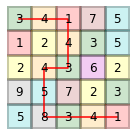

Score is : 276,480
Dice is : [1, 3, 4, 8, 5, 4]


In [38]:
solve_grid(example)

In [ ]:
solve_grid(fixed)

In [57]:
url='https://www.janestreet.com/puzzles/travel-agent-solution/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
x =[text for text in soup.body.stripped_strings]
#display([(i,j) for i,j in enumerate(x)])
display(Markdown("### "+x[8]+"\n\n"+"\n".join(x[10:13])))

### February 2016 : Solution

This month’s puzzle was, we thought, extremely challenging! We received a number
of different valid solutions. About half of these were equal to the highest
score we could find as well: about
3.35 X 10^48
. An illustration of that
solution is presented here. Congrats to everyone who managed to take a crack at
this month’s puzzle — we’ll be randomly picking a few submitters to receive Jane
Street t-shirts!


<img src="https://www.janestreet.com/puzzles/wp-content/uploads/2016/03/feb16_puzzle_solution_trimmed.png" width="400">


143


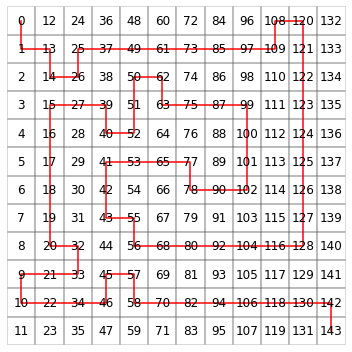

In [9]:
path =[0,1,13,14,26,25,37,49,61,73,85,97,109,108,120,121,122,123,124,125,126,127,128,116,104,92,80,68,56,55,43,42,41,53,65,
       77,78,90,102,101,100,99,87,75,63,62,50,51,52,40,39,27,15,16,17,18,19,20,32,33,21,9,10,22,34,46,45,57,58,70,82,94,106,
       118,130,142,143]+[143]*(143-77)

print(len(path))
n=12
board= [["" for i in range(n)] for j in range(n)]
for i in range(n**2):
    board[i % n][i // n] = i

fig,ax = plt.subplots(1,1,figsize=(5,5))    
ax =sns.heatmap(np.zeros((n,n)),annot=board,cbar=False,cmap='Greys',fmt="",linewidths=1,linecolor="k",annot_kws={"size":12,"color":"k"},alpha=.15)
ax.tick_params(left=False, bottom=False,labelleft=False, labelright=True)
ax.axis("off")
xpoints = [i //n+0.5 for i in path]
ypoints = [i % n+0.5 for i in path]
plt.plot(xpoints,ypoints,"r")
plt.tight_layout()
plt.show()   

In [ ]:
def neighbours(x,n):
        l=[]
        i = x % n
        j = x // n
        if i-1 >= 0:
            l.append((i-1,j))
        if i+1 < n:
            l.append((i+1,j))
        if j-1 >= 0:
            l.append((i,j-1))
        if j+1 < n:
            l.append((i,j+1))
        return [i+j*n for i,j in l]
    
neighbours(143,12)

In [ ]:
    # fix the dice for the example
    if n == 5:
        dice = [3,4,4,8,1,5]
    else:
        dice = [1,8,3,7,6,6]
   
    #s += U[0] == dice[4]
    #s += D[0] == dice[0]
    #s += L[0] == dice[1]
    #s += R[0] == dice[5]
    #s += F[0] == dice[3]
    #s += B[0] == dice[2]
    
    
    if n ==12:
        path =[0,1,13,14,26,25,37,49,61,73,85,97,109,108,120,121,122,123,124,125,126,127,128,116,104,92,80,68,56,55,43,42,41,53,65,
       77,78,90,102,101,100,99,87,75,63,62,50,51,52,40,39,27,15,16,17,18,19,20,32,33,21,9,10,22,34,46,45,57,58,70,82,94,106,
       118,130,142,143]+[143]*(143-77+1)
    
        s += [P[i] == path[i] for i in range(n**2)]